#Imports and Installs

In [1]:
!pip3 install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
pip install torch torchvision transformers datasets pillow

In [3]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 41.7 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import DatasetDict

In [5]:
from torchmetrics import Metric
from torchmetrics.detection import MeanAveragePrecision

In [6]:
from sklearn.metrics import classification_report

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data Read

In [8]:
from datasets import load_dataset

data = load_dataset("detection-datasets/fashionpedia")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.22k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

(…)-00000-of-00007-fe108070118553c3.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00001-of-00007-f41a5a9c38c9005b.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00002-of-00007-40bc8456894bcbcd.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00003-of-00007-9a99ff8dc572e02c.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00004-of-00007-f4e6f12cd2cedfea.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

(…)-00005-of-00007-41d8dfe1edb6591e.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00006-of-00007-f41b0f2f4bbefac9.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00000-of-00001-0b29e85429788213.parquet:   0%|          | 0.00/84.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45623 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1158 [00:00<?, ? examples/s]

In [9]:
data

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 45623
    })
    val: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1158
    })
})

In [10]:
data['train'][0]

{'image_id': 23,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=682x1024>,
 'width': 682,
 'height': 1024,
 'objects': {'bbox_id': [150311, 150312, 150313, 150314],
  'category': [23, 23, 33, 10],
  'bbox': [[445.0, 910.0, 505.0, 983.0],
   [239.0, 940.0, 284.0, 994.0],
   [298.0, 282.0, 386.0, 352.0],
   [210.0, 282.0, 448.0, 665.0]],
  'area': [1422, 843, 373, 56375]}}

# Data Preparation Functions

In [14]:
def has_all_valid_boxes(sample):
      boxes = sample['objects']['bbox']
      for box in boxes:
          x_min, y_min, x_max, y_max = box

          width = x_max - x_min
          height = y_max - y_min

          if width <= 0 or height <= 0:
              return False
      return True

In [15]:
def remove_invalid_samples(data):
    new_data = data.filter(has_all_valid_boxes)

    return new_data

In [ ]:
train_data = data['train']
val_data = data['val']

In [16]:
train = remove_invalid_samples(train_data)
validation = remove_invalid_samples(val_data)

Filter:   0%|          | 0/45623 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1158 [00:00<?, ? examples/s]

In [17]:
train.save_to_disk("train_dataset")
validation.save_to_disk("validation_dataset")

Saving the dataset (0/7 shards):   0%|          | 0/45614 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1158 [00:00<?, ? examples/s]

In [11]:
category = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']

# DataSet and DataLoader

In [18]:
from datasets import load_from_disk

train = load_from_disk("train_dataset")
validation = load_from_disk("validation_dataset")

In [19]:
class CustomObjectDetectionDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        """
        Args:
            hf_dataset (Dataset): Hugging Face dataset split (train or val).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieve the data example
        sample = self.dataset[idx]

        # Load the image
        image = sample['image'].convert("RGB")  # Ensure it's in RGB format

        # Get image dimensions
        width = sample['width']
        height = sample['height']

        # Get objects and annotations
        objects = sample['objects']
        boxes = objects['bbox']  # List of [x_min, y_min, x_max, y_max]
        labels = objects['category']  # List of category IDs

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Compute areas
        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Assume all instances are not crowd
        iscrowd = torch.zeros((labels.size(0),), dtype=torch.int64)

        # Remove boxes with zero or negative width/height (redundant if dataset is cleaned)
        valid_indices = (boxes[:, 2] - boxes[:, 0] > 0) & (boxes[:, 3] - boxes[:, 1] > 0)
        boxes = boxes[valid_indices]
        labels = labels[valid_indices]
        areas = areas[valid_indices]
        iscrowd = iscrowd[valid_indices]

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([sample['image_id']])
        target["area"] = areas
        target["iscrowd"] = iscrowd

        if self.transform:
            image = self.transform(image)

        return image, target


In [20]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to Tensor and scale between [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Using ImageNet means
                         std=[0.229, 0.224, 0.225])
])

In [21]:
print(train)
print(validation)

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 45614
})
Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 1158
})


In [22]:
shuffled_train = train.shuffle()
shuffled_validation = validation.shuffle()

In [ ]:
# Training on a fraction of dataset (did manually)
total_train_images = 15205
total_validation_images = 386

In [ ]:
train_hf_dataset = shuffled_train.select(range(total_train_images))
val_hf_dataset = shuffled_validation.select(range(total_validation_images))

In [23]:
print(train_hf_dataset)
print(val_hf_dataset )

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 15205
})
Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 386
})


In [24]:
# Create custom datasets
train_dataset = CustomObjectDetectionDataset(train_hf_dataset, transform=transform)
val_dataset = CustomObjectDetectionDataset(val_hf_dataset, transform=transform)

In [26]:
# Define collate function for DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

In [27]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
val_loader = DataLoader(
    val_dataset, batch_size=8, shuffle=False, num_workers=4,
    collate_fn=collate_fn
)

In [25]:
# test_loader = DataLoader(
#     test_dataset, batch_size=8, shuffle=False, num_workers=4,
#     collate_fn=collate_fn
# )

# Model - ResNet50

## Model Instantiation

In [12]:
num_classes = 47

# Load Model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 116MB/s]


In [13]:
# Move model to GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Training

In [ ]:
# Load Model from saved state
# Do NOT run if re-running
model.load_state_dict(torch.load('/content/drive/MyDrive/object_detection_model_big.pth'))
model.to(device)

<ipython-input-30-03e36390f793>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/object_detection_model_big.pth'))


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.05, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Number of epochs
num_epochs = 30

# Training and validation loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    print(f"Epoch [{epoch+1}], Training")
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)

        # Compute total loss
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        # Backward pass
        losses.backward()

        optimizer.step()

    lr_scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

    if epoch % 1 == 0:
        torch.save(model.state_dict(), f'model_epoch_{epoch}.pth')

    # Validation
    with torch.no_grad():
        val_loss = 0
        print(f"Epoch [{epoch+1}], Validation")

        for images, targets in val_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

        print(f"Validation Loss: {val_loss/len(val_loader):.4f}")

In [ ]:
torch.save(model.state_dict(), 'object_detection_model.pth')

# Model Evaluation

In [28]:
# Creating a subset Dataset for Testing
test_hf_dataset = shuffled_validation.select(range(100))
test_dataset = CustomObjectDetectionDataset(test_hf_dataset, transform=transform)
test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=collate_fn
)

In [14]:
model.load_state_dict(torch.load('/content/drive/MyDrive/object_detection_model_big.pth'))
model.to(device)
model.eval()

<ipython-input-14-6029ef84cd67>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/object_detection_model_big.pth'))


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [1]:
# Chechking the Test Loss we recieved
def evaluate_loss(model, test_loader, device):
    model.train()
    total_loss = 0.0

    with torch.no_grad():
        for images, targets in test_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            total_loss += sum(loss for loss in loss_dict.values()).item()

    average_loss = total_loss / len(test_loader)
    return average_loss

loss = evaluate_loss(model, test_loader, device)
print(f"Test Loss: {loss}")

Test Loss: 0.6100619921088218


In [17]:
def get_prediction(model, image, threshold):
    model.eval()
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    img = transform(image).to(device)
    with torch.no_grad():
        predictions = model([img])
    print(predictions)
    pred_boxes = predictions[0]['boxes'].cpu().numpy()
    pred_labels = predictions[0]['labels'].cpu().numpy()
    pred_scores = predictions[0]['scores'].cpu().numpy()

    # Filter based on threshold
    mask = pred_scores >= threshold
    pred_boxes = pred_boxes[mask]
    pred_labels = pred_labels[mask]
    pred_scores = pred_scores[mask]

    return pred_boxes, pred_labels, pred_scores

In [36]:
def evaluate_model(model, test_loader, device):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox").to(device)

    with torch.no_grad():
        for images, targets in tqdm(test_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            # target_labels = targets[0]['labels']
            # target_labels = torch.as_tensor([l + 1 for l in target_labels])
            # targets[0]['labels'] = targets[0]['labels'].to(device) + 1

            predictions = model(images)
            # print(targets)


            preds = [
                dict(
                    boxes = predictions[0]['boxes'],
                    labels = predictions[0]['labels'],
                    scores = predictions[0]['scores']
                )
            ]

            targs = [
                dict(
                    boxes = targets[0]['boxes'],
                    labels = targets[0]["labels"] # Add +1 to every label in target
                )
            ]

            # print(preds)
            # print(targs)
            # break
            for pred, targ in zip(preds, targs):
              metric.update(preds, targs)

    mAP = metric.compute()
    return mAP

mAP = evaluate_model(model, test_loader, device)
print(f"Mean Average Precision (mAP): {mAP}")

100%|██████████| 100/100 [00:13<00:00,  7.69it/s]


Mean Average Precision (mAP): {'map': tensor(0.3401), 'map_50': tensor(0.5325), 'map_75': tensor(0.3721), 'map_small': tensor(0.1231), 'map_medium': tensor(0.3421), 'map_large': tensor(0.4414), 'mar_1': tensor(0.3843), 'mar_10': tensor(0.4475), 'mar_100': tensor(0.4500), 'mar_small': tensor(0.2027), 'mar_medium': tensor(0.4046), 'mar_large': tensor(0.5526), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=torch.int32)}


In [ ]:
# To be disregard
def evaluate_classification(model, test_loader, device):
    model.eval()
    all_true_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for images, targets in tqdm(test_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            predictions = model(images)

            for pred, targ in zip(predictions, targets):
                num_true_boxes = targ['labels'].shape[0]

                pred_labels = pred['labels'].cpu().numpy()
                pred_scores = pred['scores'].cpu().numpy()

                # Filter predictions based on a score threshold (e.g., 0.5)
                mask = pred_scores >= 0.5
                filtered_pred_labels = pred_labels[mask]

                # Pad or truncate predicted labels
                if len(filtered_pred_labels) < num_true_boxes:
                    # Pad with -1
                    filtered_pred_labels = np.pad(filtered_pred_labels, (0, num_true_boxes - len(filtered_pred_labels)), 'constant', constant_values=-1)
                elif len(filtered_pred_labels) > num_true_boxes:
                    # Truncate
                    filtered_pred_labels = filtered_pred_labels[:num_true_boxes]

                all_true_labels.extend(targ['labels'].cpu().numpy().tolist())
                all_pred_labels.extend(filtered_pred_labels.tolist())

    report = classification_report(all_true_labels, all_pred_labels)
    print(report)

evaluate_classification(model, test_loader, device)

100%|██████████| 1158/1158 [02:39<00:00,  7.27it/s]

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00       102
           1       0.10      0.10      0.10       477
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00        12
           4       0.07      0.07      0.07       183
           5       0.00      0.00      0.00        22
           6       0.12      0.14      0.13       314
           7       0.18      0.17      0.17       106
           8       0.09      0.10      0.10       162
           9       0.05      0.04      0.04       104
          10       0.15      0.17      0.16       508
          11       0.00      0.00      0.00        21
          12       0.00      0.00      0.00         5
          13       0.12      0.12      0.12       130
          14       0.06      0.07      0.07        74
          15       0.15      0.12      0.13       109
          16       0.00    


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/

## Visualsation

In [19]:
def visualize_predictions(image, boxes, labels, scores, category_names, score_threshold=0.5):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    for box, label, score in zip(boxes, labels, scores):
        if score < score_threshold:
            continue
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='red', linewidth=2)

        ax.add_patch(rect)
        ax.text(x_min, y_min, f"{category_names[label]}: {score:.2f}", bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

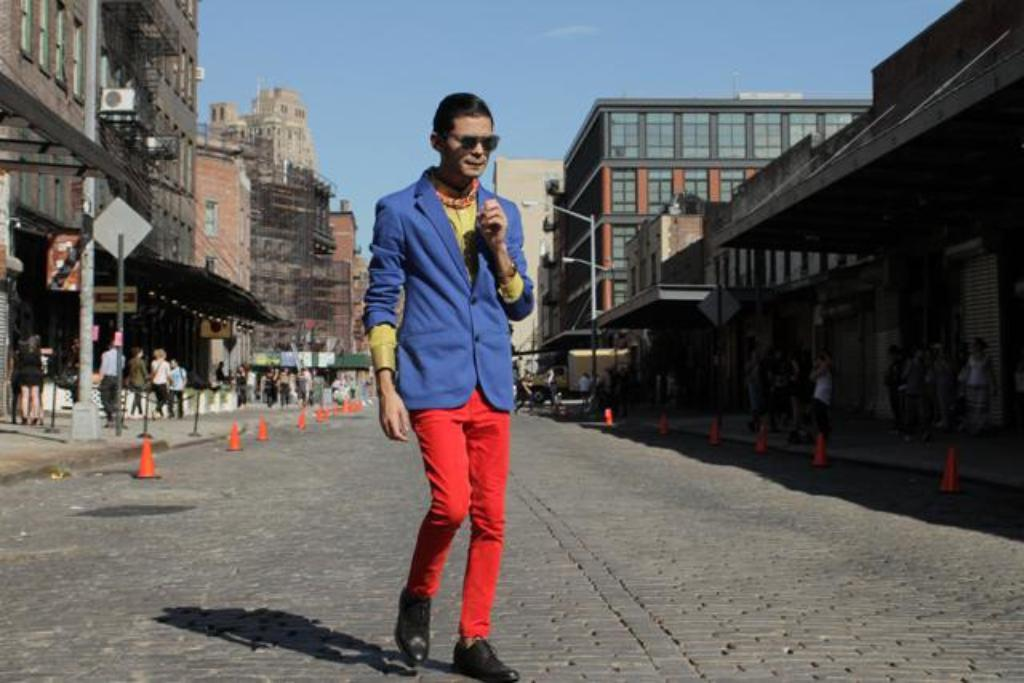

In [15]:
data['train'][2]["image"]

[{'boxes': tensor([[298.1258, 429.4427, 457.8705, 843.7294],
        [382.8555, 841.6213, 432.2298, 898.5938],
        [246.8605, 217.5709, 298.2306, 510.4387],
        [457.4123, 224.0341, 494.5566, 514.0626],
        [352.6482, 217.5769, 446.9559, 435.7439],
        [246.8425, 178.2170, 496.4372, 524.8306],
        [333.4667, 171.4878, 442.9623, 236.9367],
        [364.9600, 217.2387, 410.3413, 231.7728],
        [305.2868, 744.4321, 344.6661, 832.7106],
        [340.8288, 231.4501, 371.6343, 481.5224],
        [442.0479, 270.0839, 467.8922, 284.0683],
        [422.3499, 250.4837, 475.6369, 509.4033],
        [441.4126, 268.2459, 468.8084, 347.0354],
        [440.5762, 267.7940, 468.2884, 295.9228],
        [407.4709, 236.1329, 457.3682, 488.7020],
        [290.5217, 354.7187, 302.4846, 416.0576],
        [341.3549, 243.1671, 357.5925, 475.4056],
        [448.5411, 288.0922, 465.9516, 349.3482],
        [325.4229, 184.6849, 454.1859, 379.6095],
        [450.1160, 269.6284, 467.0954, 

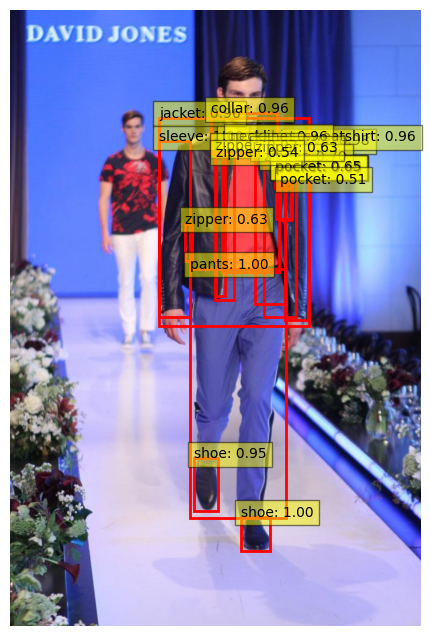

In [21]:
# Load a new image
# for image, targets in test_loader:
#   new_image, target = images[0], targets[0]

new_image = data['train'][3]["image"]  # Replace with your image path

# Get predictions
boxes, labels, scores = get_prediction(model, new_image, threshold=0.5)

# Visualize predictions
visualize_predictions(new_image, boxes, labels, scores, category, score_threshold=0.5)